In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime
%matplotlib inline 
# This code is derived from AWS SageMaker Samples:
# https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/deepar_electricity
# https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/deepar_synthetic

<h2>DeepAR - Kaggle Bike Sharing Demand Dataset</h2>
<h4>Prepare Bike Rental Data for DeepAR training</h4>  
<quote>We will store the total rental count, registered rental count, and casual rental count data as a time series.</quote>
<quote>For each of the targets <b>total, registered, casual</b>, following JSON is structured as: Start Time, Array of target values, optional dynamic features and categories</quote>
<quote>Frequency of time series data (for example, hourly, daily, monthly and so forth) is specified using hyperparameter</quote>



In [89]:
target_values = ['Close/Last']

with_categories = False

# Set datetime column as index to work with data based on Date/Time
df = pd.read_csv('AAPL_resampled.csv',parse_dates=[0], index_col=0)


In [90]:
df.dtypes

Close/Last    float64
Volume        float64
Open          float64
High          float64
Low           float64
dtype: object

## Minimum time and Maximum Time in Training CSV file
df.index.min(),df.index.max()

In [91]:
df.index.min(),df.index.max()

(Timestamp('2019-12-23 00:00:00'), Timestamp('2020-12-22 00:00:00'))

In [92]:
df['2020-11']

,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-11-01,106.992,1.580225e+08,109.501,109.952,106.132
2020-11-02,108.770,1.228669e+08,109.110,110.680,107.320
2020-11-03,110.440,1.076244e+08,109.660,111.490,108.730
2020-11-04,114.950,1.382355e+08,114.140,115.590,112.350
2020-11-05,119.030,1.263871e+08,117.950,119.620,116.869
2020-11-06,118.690,1.144579e+08,118.320,119.200,116.130
2020-11-07,117.845,1.230159e+08,119.758,120.338,115.888
2020-11-08,117.195,1.480394e+08,122.225,123.206,116.821
2020-11-09,116.320,1.545153e+08,120.500,121.990,116.050


In [93]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html
    
freq='D' # Timeseries consists Daily Data 

# how far in the future predictions can be made
# 5 days worth of daily forecast 
prediction_length = 5 

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 15
mn=df.index.min()
mx=df.index.max()
mn,mx

(Timestamp('2019-12-23 00:00:00'), Timestamp('2020-12-22 00:00:00'))

In [94]:
dt_predict_max = pd.Timestamp(mx, freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)

dt_dataset_start_time = pd.Timestamp(mn, freq=freq)
dt_dataset_end_time = pd.Timestamp(mx, freq=freq)

# use for model training
# Start time is the first row 
# Training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing
dt_train_range = (dt_dataset_start_time,
                  dt_dataset_end_time - datetime.timedelta(days=5 )

# Use entire data for testing
# We can compare predicted values vs actual (i.e. last 12 days is withheld for testing and model hasn't seen that data)
dt_test_range = (dt_dataset_start_time, 
                 dt_dataset_end_time) 
dt_train_range,dt_test_range 

SyntaxError: invalid syntax (<ipython-input-94-1ad911f455fe>, line 15)

In [95]:
dt_predict_max,dt_predict_max + datetime.timedelta(days=1)

(Timestamp('2020-12-22 00:00:00', freq='D'),
 Timestamp('2020-12-23 00:00:00', freq='D'))

In [96]:
# Skip this because missing values are fixed in another code file
# Let's see if there are gaps in timesteps
def is_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return not dt_range.equals(df[start:end].index)

def get_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return dt_range.difference(df[start:end].index)    

# List timeseries with only NaNs
# They can be removed
def timeseries_with_only_nans(df):
    l = []
    for col in df.columns:
        if pd.isna(df[col].min()):
            #print (col)
            l.append(col)
    return l

In [97]:
is_missing_steps(df, '2020-01-01', '2020-01-19','D')

False

In [98]:
get_missing_steps(df, '2020-01-01', '2020-01-19','D')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [99]:
df.tail()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-12-18,126.655,1.925415e+08,128.960,129.100,126.120
2020-12-19,125.525,2.116398e+08,126.985,127.724,123.610
2020-12-20,126.103,1.428517e+08,123.792,126.280,121.619
2020-12-21,128.230,1.212516e+08,125.020,128.310,123.449
2020-12-22,131.880,1.693518e+08,131.610,134.405,129.650


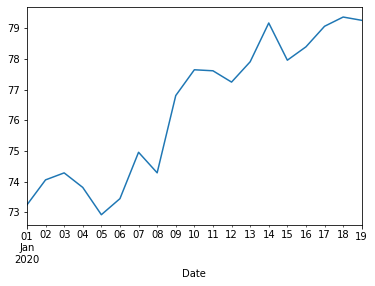

In [100]:
df['2020-01-01': '2020-01-19']['Open'].plot()

In [101]:
target_values

['Close/Last']

In [102]:
dt_test_range

(Timestamp('2019-12-23 00:00:00', freq='D'),
 Timestamp('2020-12-22 00:00:00', freq='D'))

In [103]:
dt_train_range

(Timestamp('2019-12-23 00:00:00', freq='D'),
 Timestamp('2020-12-07 00:00:00', freq='D'))

In [104]:
time_series_test = []
time_series_training = []

for target in target_values:
    #time_series_training.append(df[:-prediction_length])
    #time_series_test.append(df)
    time_series_test.append(df[dt_test_range[0]:dt_test_range[1]][target])
    time_series_training.append(df[dt_train_range[0]:dt_train_range[1]][target])

In [105]:
time_series_test[0].tail()

Date
2020-12-18    126.655
2020-12-19    125.525
2020-12-20    126.103
2020-12-21    128.230
2020-12-22    131.880
Name: Close/Last, dtype: float64

In [106]:
time_series_training[0].tail()

Date
2020-12-03    122.940
2020-12-04    122.250
2020-12-05    122.129
2020-12-06    122.737
2020-12-07    123.750
Name: Close/Last, dtype: float64

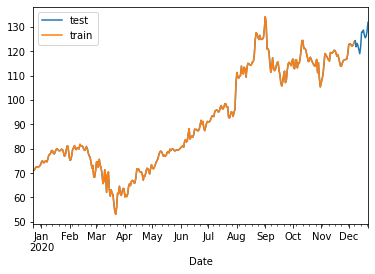

In [107]:
time_series_test[0].plot(label='test')
time_series_training[0].plot(label='train')#, ls=':')
plt.legend()
plt.show()

In [108]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))   

In [109]:
list(time_series_training[0][:5])

[71.0, 71.068, 71.808, 72.47800000000001, 72.45]

In [110]:
series_to_obj(time_series_training[0][:5],[0] if with_categories else None)

{'start': '2019-12-23 00:00:00',
 'target': [71.0, 71.068, 71.808, 72.47800000000001, 72.45]}

In [111]:
series_to_jsonline(time_series_training[0][:5],[0] if with_categories else None)

'{"start": "2019-12-23 00:00:00", "target": [71.0, 71.068, 71.808, 72.47800000000001, 72.45]}'

In [112]:
encoding = "utf-8"
cat_idx = 0

train_file_name = "AAPLtrain.json"
test_file_name = "AAPLtest.json"

if with_categories:
    train_file_name = "AAPLtrain_with_categories.json"
    test_file_name = "AAPLtest_with_categories.json"

with open(train_file_name, 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts,[cat_idx] if with_categories else None).encode(encoding))
        fp.write('\n'.encode(encoding))
        cat_idx += 1

In [113]:
cat_idx = 0
with open(test_file_name, 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts,[cat_idx] if with_categories else None).encode(encoding))
        fp.write('\n'.encode(encoding))
        cat_idx += 1

In [114]:
df.to_csv('all_data.csv',index=True,index_label='datetime')

In [115]:
for ts in time_series_test:
    print (len(ts),ts.name)


366 Close/Last


In [116]:
for ts in time_series_training:
    print (len(ts),ts.name)

351 Close/Last
